- https://www.robots.ox.ac.uk/~vgg/hzbook/hzbook1/HZepipolar.pdf
- http://www.uio.no/studier/emner/matnat/its/UNIK4690/v16/forelesninger/lecture_7_1-epipolar-geometry.pdf
- https://github.com/marktao99/python/blob/master/CVP/samples/sfm.py#L85

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_row_A(pair, pair_prime):
    x, y = pair[0], pair[1]
    x_p, y_p = pair_prime[0], pair_prime[1]
    return [x*x_p, y*x_p, x_p, x*y_p, y*y_p, y_p, x, y, 1]

def build_A(pairs, pairs_prime):
    A = np.zeros((pairs.shape[0], 9))
    for i, pair in enumerate(zip(pairs, pairs_prime)):
        A[i] = get_row_A(*pair)
    
    return A

def get_fundemental_matrix(pairs, pairs_prime):
    A = build_A(pairs, pairs_prime)
    u, s, v = np.linalg.svd(A, full_matrices = False)
    f_bar = v[-1].reshape(3,3)
    u_hat, s_hat, v_hat = np.linalg.svd(f_bar, full_matrices = False)
    s_hat[-1] = 0
    f_hat = np.dot(u_hat, np.dot(np.diag(s_hat), v_hat))
    return f_hat


def get_fundemental_matrix_normalised(pairs, pairs_prime):
    
    mean = np.mean(pairs, axis = 0)
    s = np.sqrt(2) / np.std(pairs)
    T = np.array([
        [s, 0, -s * mean[0]],
        [0, s, -s * mean[1]],
        [0, 0, 1]
    ])
    norm_pairs = np.dot(pairs, T)
    
    mean = np.mean(pairs_prime, axis = 0)
    s = np.sqrt(2) / np.std(pairs_prime)
    T_prime = np.array([
        [s, 0, -s * mean[0]],
        [0, s, -s * mean[1]],
        [0, 0, 1]
    ])
    norm_pairs_prime = np.dot(pairs_prime, T_prime)
    
    F = get_fundemental_matrix(norm_pairs, norm_pairs_prime)
    
    denormed_F = np.dot(T, np.dot(F, T_prime))
    
    return denormed_F
    

def compute_epipole(F):
    """ 
    Computes the (right) epipole from a 
    fundamental matrix F. 
    (Use with F.T for left epipole.) 
    """
    
    # return null space of F (Fx=0)
    U,S,V = np.linalg.svd(F)
    e = V[-1]
    return e/e[2]

-0.266025354029 5.28300042579


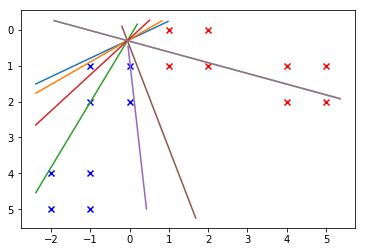

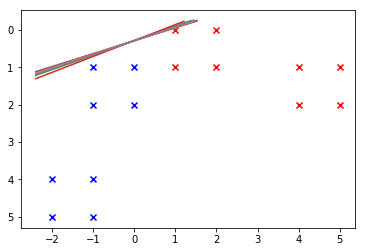

In [3]:
pairs = np.array([
    [0, 1],
    [0, 2],
    [1, 2],
    [1, 1],
    [1, 4],
    [1, 5],
    [2, 5],
    [2, 4]
])
pairs = np.concatenate((pairs, np.ones((pairs.shape[0], 1))), axis = 1)

plt.scatter(pairs[:, 1], pairs[:, 0], marker='x', c='r')

H = np.array([
    [0, 1, 0],
    [-1, 0, 0],
    [0, 0, 1]
]) # simple left rotation, no translation

pairs_prime = H.dot(pairs.T).T

plt.scatter(pairs_prime[:, 1], pairs_prime[:, 0], marker='x', c='b')
plt.gca().invert_yaxis()

F = get_fundemental_matrix_normalised(pairs, pairs_prime)
x_bound = plt.gca().get_xbound()
y_min, y_max = plt.gca().get_ybound()
print(y_min, y_max)

for p in pairs_prime:
    line = np.dot(F, p)
    space = np.linspace(*x_bound, 100)
    
    eq = (line[2] + line[0] * space) / -line[1]
    selector = np.logical_and(y_min < eq, eq < y_max)
    space = space[selector]
    eq = eq[selector]
    
    plt.plot(space, eq)
    
plt.show()

plt.scatter(pairs[:, 1], pairs[:, 0], marker='x', c='r')
plt.scatter(pairs_prime[:, 1], pairs_prime[:, 0], marker='x', c='b')
plt.gca().invert_yaxis()

for p in pairs:
    line = np.dot(F, p)
    space = np.linspace(*x_bound, 100)
    
    eq = (line[2] + line[0] * space) / -line[1]
    selector = np.logical_and(y_min < eq, eq < y_max)
    space = space[selector]
    eq = eq[selector]
    
    plt.plot(space, eq)
    
plt.show()

Loading Annotator in data load mode...
Found annotations for images/bridge_left.JPG @ bridge_left_annotation.txt, loading...
Found annotations for images/bridge_right.JPG @ bridge_right_annotation.txt, loading...


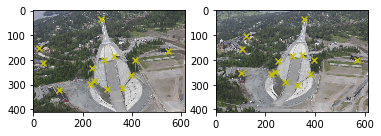

[[ -4.49290505e-03   1.43214759e-02  -3.17040555e+00]
 [ -3.78971841e-03   1.20271517e-02  -2.65219795e+00]
 [  1.75581887e-03  -5.58858852e-03   1.23556781e+00]]


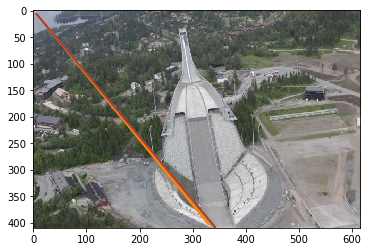

In [4]:
from src.annotator import Annotator
ann = Annotator('images/bridge_left.JPG', 'images/bridge_right.JPG', annotation_mode=False)
ann.display_images(show=True)
points = np.array(ann.coords)
images = ann.images

left = np.concatenate((points[0], np.ones((points[0].shape[0], 1))), axis=1)
right = np.concatenate((points[1], np.ones((points[1].shape[0], 1))), axis=1)

F = get_fundemental_matrix_normalised(left, right)
print(F)

plt.imshow(images[0])
x_bound = plt.gca().get_xbound()
y_min, y_max = plt.gca().get_ybound()

for p in right:
    line = np.dot(F, p)
    space = np.linspace(*x_bound, 100)
    
    eq = (line[2] + line[0] * space) / line[1]
    selector = np.logical_and(y_min < eq, eq < y_max)
    space = space[selector]
    eq = eq[selector]
    
    plt.plot(space, eq)

NameError: name 'normal' is not defined

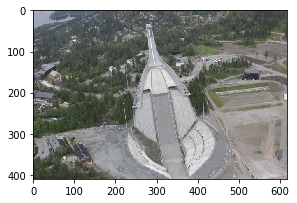

In [5]:
point=0
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(images[0])
plt.scatter(normal[point, 0], normal[point, 1], marker='x', c='r')
plt.subplot(1, 2, 2)
plt.imshow(images[1])
plt.scatter(rotated[point, 0], rotated[point, 1], marker='x', c='r')
plt.show()